In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [5]:
len(y_train), len(y_test)

(60000, 10000)

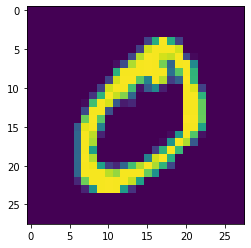

tensor(0)


In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[1, :, :])
plt.show()
print(y_train[1])

В отличие от полносвязанной сети, которая видела картинку как один длинный вектор, мы хотим в конв-ю сеть передавать картинку как трёхмерный тензор. 

Первый канал - это глубина картинки, в черно-белой картинке это 1 канал с яркостью серого пикселя. А в RGB картинке будут RGB каналы. 

Соответственно, мы должны нашу картинку, которая пришла на вход (она просто "28 на 28"), разжать до "1 на 28 на 28".

In [8]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [9]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [24]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        # растянем наш 4х мерный тензор (1я размерность отвечает за размер батча)
        # view преобразует тензор к нужной размерности
        # x.size(0) - размер батча
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [26]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet5.parameters(), lr=1.0e-4)

In [27]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(200):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch)
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    # ВАЖНО. Использовать связку .data.cpu()
    # Без этого в loss хранится не одно число, а весь граф вычислений, 
    # из-за чего на gpu происходит утечка памяти

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(0.7613)
tensor(0.8482)
tensor(0.8809)
tensor(0.8960)
tensor(0.9101)
tensor(0.9176)
tensor(0.9243)
tensor(0.9280)
tensor(0.9331)
tensor(0.9347)
tensor(0.9381)
tensor(0.9390)
tensor(0.9421)
tensor(0.9451)
tensor(0.9465)
tensor(0.9482)
tensor(0.9508)
tensor(0.9512)
tensor(0.9529)
tensor(0.9554)
tensor(0.9549)
tensor(0.9556)
tensor(0.9579)
tensor(0.9595)
tensor(0.9592)
tensor(0.9609)
tensor(0.9613)
tensor(0.9631)
tensor(0.9628)
tensor(0.9645)
tensor(0.9650)
tensor(0.9662)
tensor(0.9652)
tensor(0.9676)
tensor(0.9675)
tensor(0.9687)
tensor(0.9687)
tensor(0.9687)
tensor(0.9695)
tensor(0.9691)
tensor(0.9704)
tensor(0.9707)
tensor(0.9711)
tensor(0.9720)
tensor(0.9709)
tensor(0.9716)
tensor(0.9719)
tensor(0.9722)
tensor(0.9730)
tensor(0.9740)
tensor(0.9733)
tensor(0.9740)
tensor(0.9741)
tensor(0.9740)
tensor(0.9739)
tensor(0.9744)
tensor(0.9749)
tensor(0.9748)
tensor(0.9756)
tensor(0.9760)
tensor(0.9762)
tensor(0.9755)
tensor(0.9761)
tensor(0.9762)
tensor(0.9765)
tensor(0.9764)
tensor(0.9

KeyboardInterrupt: ignored

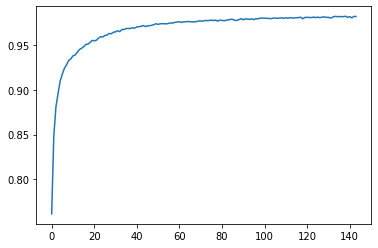

In [28]:
plt.plot(test_accuracy_history);


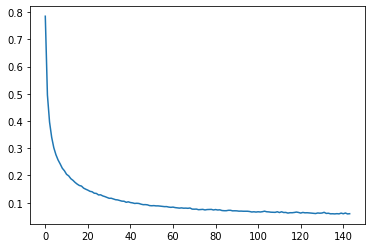

In [29]:
plt.plot(test_loss_history);